In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from timm import create_model
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast  # Added for mixed precision

In [4]:
BASE_DIR = "data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")
WORK_DIR  = "work_pytorch"
os.makedirs(WORK_DIR, exist_ok=True)

In [2]:
IMG_SIZE = 299
BATCH_SIZE = 32  # Try 32 or 64, adjust if OOM occurs
EPOCHS = 20
LR = 1e-4
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# Dataset
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_tfms)

# Calculate class weights for imbalance
num_fake = len(os.listdir(os.path.join(TRAIN_DIR, 'fake')))
num_real = len(os.listdir(os.path.join(TRAIN_DIR, 'real')))
total_samples = num_fake + num_real
class_weights = torch.tensor([total_samples / (2.0 * num_fake), total_samples / (2.0 * num_real)]).to(device)
print(f"Fake: {num_fake}, Real: {num_real}, Weights: {class_weights}")

# Split train into train/val
train_size = int(0.8 * len(train_ds))
val_size = len(train_ds) - train_size
train_subset, val_subset = random_split(train_ds, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)

print("Train samples:", len(train_subset), "Val samples:", len(val_subset), "Test samples:", len(test_ds))
print("Classes:", train_ds.classes)

Fake: 22080, Real: 15319, Weights: tensor([0.8469, 1.2207], device='cuda:0')
Train samples: 29919 Val samples: 7480 Test samples: 16672
Classes: ['fake', 'real']


In [6]:
model = create_model("xception", pretrained=True, num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

c:\Users\shrav\Deepfake-Detection-System\myenv\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
c:\Users\shrav\Deepfake-Detection-System\myenv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:
import os
from torch.cuda.amp import GradScaler, autocast  # Ensure these are imported

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Check for existing checkpoint to resume training
checkpoint_path = os.path.join(WORK_DIR, "xception_checkpoint.pth")
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scaler_state_dict' in checkpoint:  # Check if scaler state exists
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("No checkpoint found, starting from epoch 1")

# Training loop with gradient accumulation
accum_steps = 4  # Accumulate gradients over 4 steps (effective batch size = 32*4 = 128)
best_val_loss = float('inf')
for epoch in range(start_epoch, EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    optimizer.zero_grad()  # Clear gradients at start of epoch
    for i, (imgs, labels) in enumerate(loop):
        imgs, labels = imgs.to(device), labels.to(device)

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels) / accum_steps  # Normalize loss
        scaler.scale(loss).backward()  # Accumulate scaled gradients

        if (i + 1) % accum_steps == 0:  # Update every accum_steps
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * imgs.size(0) * accum_steps  # Unscale for logging
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item() * accum_steps)

    # Final update if any gradients remain
    if (i + 1) % accum_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    train_acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss={total_loss/total:.4f}, Acc={train_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    val_loss_avg = val_loss / val_total
    print(f"Epoch {epoch+1}: Val Loss={val_loss_avg:.4f}, Acc={val_acc:.4f}")

    # Step scheduler
    scheduler.step(val_loss_avg)

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'val_loss': val_loss_avg
    }, checkpoint_path)

    # Save best model based on validation loss
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        torch.save(model.state_dict(), os.path.join(WORK_DIR, "xception_best.pth"))
        print(f"Saved best model with Val Loss={val_loss_avg:.4f}")

print(f"Training completed. Best model saved to {os.path.join(WORK_DIR, 'xception_best.pth')}")

Resuming training from epoch 20
Training completed. Best model saved to work_pytorch\xception_best.pth


In [8]:
model.eval()
all_labels, all_probs = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 0]  # Probability of fake (class 0)

        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = torch.tensor(all_labels).numpy()
all_probs = torch.tensor(all_probs).numpy()
preds = (all_probs > 0.5).astype(int)

Testing: 100%|██████████| 521/521 [04:08<00:00,  2.09it/s]


In [9]:
print("ROC AUC:", roc_auc_score(1 - all_labels, all_probs))  # Invert labels: fake=1, real=0
print(classification_report(1 - all_labels, preds, target_names=['real', 'fake']))
print("Confusion Matrix:\n", confusion_matrix(1 - all_labels, preds))

ROC AUC: 0.875878807989855
              precision    recall  f1-score   support

        real       0.53      0.94      0.68      3876
        fake       0.97      0.75      0.85     12796

    accuracy                           0.79     16672
   macro avg       0.75      0.84      0.76     16672
weighted avg       0.87      0.79      0.81     16672

Confusion Matrix:
 [[3628  248]
 [3175 9621]]


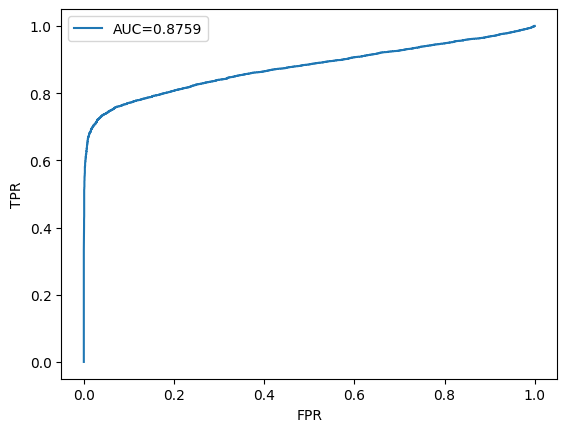

In [10]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(1 - all_labels, all_probs)  # Invert labels for fake-positive
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(1 - all_labels, all_probs):.4f}")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.savefig(os.path.join(WORK_DIR, "roc_curve.png"))
plt.show()